In [14]:
#Import packages that is reqiured
import scipy.io as io
import h5py
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Conv2D,Dropout,BatchNormalization,Cropping2D,Convolution2D,MaxPooling2D,AveragePooling2D
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling
from keras.optimizers import Adam
import numpy as np
import cv2
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [15]:
# Load the mat data files here and convert them into csv files 
lap1 = io.loadmat('bestdata')
lap2 = io.loadmat('exceptionalcases')
#removing the unwanted parts from the keys
del lap1['__header__']
del lap1['__version__']
del lap1['__globals__']
del lap2['__header__']
del lap2['__version__']
del lap2['__globals__']
#printing the total number of images in both the files used (containing the data collected)
print("Total number of images in lap1:",len(lap1))
print("Total number of images in lap2:",len(lap2))


Total number of images in lap1: 3481
Total number of images in lap2: 790


In [16]:
#combine both the dictionaries lap1 and lap2 into one single lap dictionary

#lap = lap1.copy()
#lap.update(lap2)
#print("Total number of images in lap:",len(lap))

In [17]:
#Creating arrays named images and measurments to store the images (values of the dictionary) and the steer (in the key of the directory )
#Creating arrays named images and measurments to store the images (values of the dictionary) and the throttle (in the key of the directory )
images=[]
measurement=[]
throttle=[]
for key in lap1.keys():
    images.append(lap1[key])
    measurement.append(float(key.split("_")[2]))
    throttle.append(float(key.split("_")[4]))
#Printing the number os times the steer had value 0 that is vehicle is moving in straight line
#print("Number of 0: ",measurments.count(0.00))


In [18]:
# here we are doing some data augmentation
# if the steer is not 0 or the car is deviated with an angle , here the image is flipped and more data is acquired
  #  if measurement!=0.00:
   #     augment_images.append(cv2.flip(image,1))
    #    augment_measurement.append(measurement*-1)
     #   augment_images.append(image)
      #  augment_measurement.append(measurement)
        
 #   else:
augment_images=[]
augment_measurement=[]
augment_throttle=[]
for image,throttle in zip(images,throttle):
    flip_prob = np.random.random()
   # if measurment!=0.00:
        #augment_images.append(cv2.flip(image,1))
        #augment_throttle.append(throttle)
        #augment_measurement.append(measurment*-1)
       # augment_images.append(image)
        #augment_throttle.append(throttle)
       # augment_measurement.append(measurment)
    if flip_prob > 0.65:
        #augment_measurement.append(measurment)
        augment_images.append(image)
        augment_throttle.append(throttle)
    #we store both the input in X_train and the output in the Y_train
X_train = np.array(augment_images)
Y_train = np.array(augment_throttle)
#Y_train = np.array(augment_measurement)

In [19]:
print("Number of 0: ",augment_measurement.count(0.00))
print("number of -1 and +!  ",len(augment_throttle))
INPUT_SHAPE=(240,320,3)

Number of 0:  0
number of -1 and +!   1252


In [20]:
model = Sequential()
model.add(Lambda(lambda x: x/255 , input_shape=INPUT_SHAPE))
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2)))
#model.add(Conv2D(64, 3, 3, activation='elu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(50, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='elu'))
model.add(Dense(1)) 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 240, 320, 3)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 118, 158, 24)  1824        lambda_3[0][0]                   
____________________________________________________________________________________________________
batchnormalization_7 (BatchNorma (None, 118, 158, 24)  96          convolution2d_7[0][0]            
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 118, 158, 24)  0           batchnormalization_7[0][0]       
___________________________________________________________________________________________

In [21]:
#here we are using various features for our model training 
# early stopping = that if the loss doesnot drop in 10 epochs it would stop the training there itself
# reduceLROnPlateau so that if in 5 epoch the factor of 0.1 in the losses remains same (like 0.7... remains 0.7...) it would decrease the learning rate
#ModelCheckPoint would save the model in the file mentioned and would  save the best model 
checkpoint = [EarlyStopping(patience=10,verbose=0),
              ReduceLROnPlateau(factor=0.1,patience=5,min_lr=0.000001,verbose=0),
              ModelCheckpoint('model_tt2.h5',monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=True)      ]
#in model.compile the loss for the training is defined and also the optimizer with the learning rate
model.compile(loss='mse', optimizer=Adam(lr=0.0001))

In [22]:
#here the training starts with batch size , splitting and epochs defined 
history_object=model.fit(X_train,Y_train,batch_size=32,validation_split=0.2,shuffle=True,nb_epoch=100,callbacks=checkpoint)


Train on 1001 samples, validate on 251 samples
Epoch 1/100


KeyboardInterrupt: 

dict_keys(['val_loss', 'loss', 'lr'])


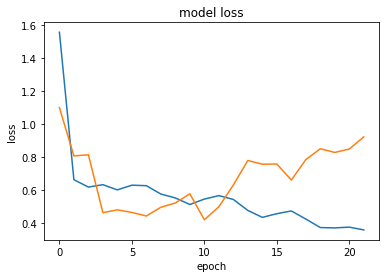

In [23]:
#print the loss curves of both training and validation 
history=history_object
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()